In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

## 01 Load Data

In [3]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [4]:
good_roast = X[np.where(Y == 1)[0]]
bad_roast = X[np.where(Y == 0)[0]]

print(good_roast.shape)

(43, 2)


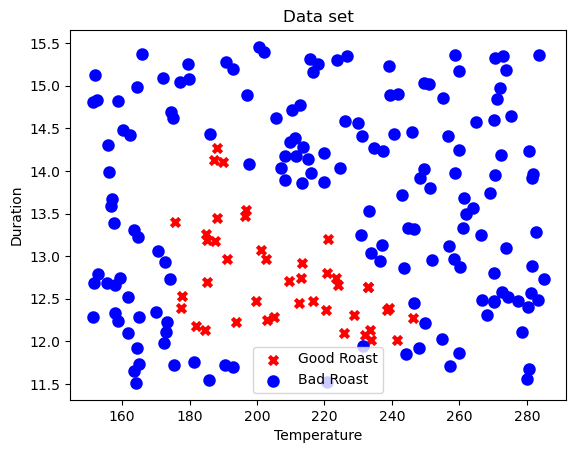

In [5]:
plt.scatter(good_roast[:, 0], good_roast[:, 1], label = 'Good Roast', color = 'red', marker = 'x', linewidths = 3)
plt.scatter(bad_roast[:, 0], bad_roast[:, 1], label = 'Bad Roast', color = 'blue', marker = 'o', linewidths = 3)

plt.xlabel('Temperature')
plt.ylabel('Duration')
plt.title('Data set')

plt.legend()
plt.show()

## 02 Normalise Data

We can normalise data by *Keras Normalisation layer*.

- **create** a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- **'adapt'** the data. This learns the mean and variance of the data set and saves the values internally.
- **normalize** the data.  

In [6]:
# Create layer
norm_layer = tf.keras.layers.Normalization(axis = -1)

# Adapt
norm_layer.adapt(X)

# Get normalised data
X_normalised = norm_layer(X)

In [9]:
X_normalised.shape

TensorShape([200, 2])

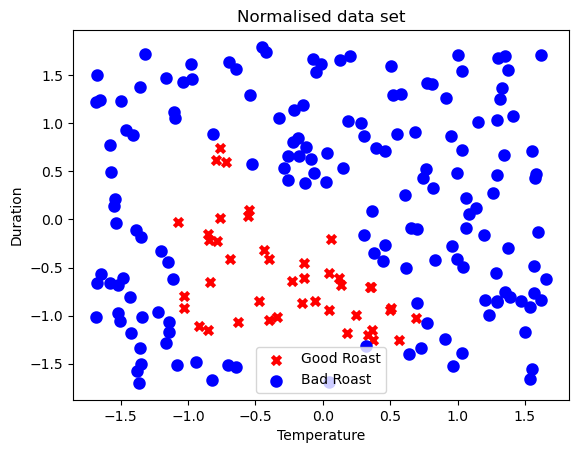

In [10]:
good_roast = np.array(X_normalised)[np.where(Y == 1)[0]]
bad_roast = np.array(X_normalised)[np.where(Y == 0)[0]]

plt.scatter(good_roast[:, 0], good_roast[:, 1], label = 'Good Roast', color = 'red', marker = 'x', linewidths = 3)
plt.scatter(bad_roast[:, 0], bad_roast[:, 1], label = 'Bad Roast', color = 'blue', marker = 'o', linewidths = 3)

plt.xlabel('Temperature')
plt.ylabel('Duration')
plt.title('Normalised data set')

plt.legend()
plt.show()

#### Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [11]:
Xt = np.tile(X_normalised,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


## 03 Construct Tensorflow Model

### Model

<center> <img  src="./images/neuron_1.png" width="200" />   <center/>
    
We can use tensorflow to construct a model sequence.

In [12]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


## 04 Train

In [14]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1960
Epoch 2/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1220
Epoch 3/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0967
Epoch 4/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0235
Epoch 5/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0138
Epoch 6/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0096
Epoch 7/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0070
Epoch 8/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0051
Epoch 9/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0037
Epoch 10/10
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0028


**Get parameters**

In [15]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 1.4527825e+01 -1.7992199e-03  1.2628060e+01]
 [ 1.2062020e+01 -8.9537811e+00  3.2502127e-01]] 
b1: [  1.7787288 -11.24895    13.157907 ]
W2:
 [[-41.71388 ]
 [-43.91733 ]
 [ 37.411503]] 
b2: [-12.116689]


**Make prediction**

In [18]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_layer(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 68ms/step
predictions = 
 [[9.8691475e-01]
 [7.3316350e-08]]
